[//]: # "Para temas claros usar logo_utn.svg"
<img src="./logo_utn_dark.png" align="right" width="250" /> 

# Análisis de la sensibilidad en la topología Sallen-Key

#### Por Mariano Llamedo Soria

### Introducción


En el siguiente documento analizaremos la dispersión de parámetros $Q$, $\omega_0$ y la ganancia $K$ correspondiente a una topología Sallen-Key en su configuración pasabajo

<img src="./sallenkey.png" align="center" width="700" style="border:10px solid white" /> 

Comenzaremos analizando las ecuaciones que gobiernan el comportamiento de la red:





 1. Nodo $V_b$
 
  $ V_b . (G_1 + G_2 + s.C) - V_i . G_1 - V_a . G_2  - V_o . s.C = 0$


 2. Nodo $V_a$ ó $V_+$
 
  $ -V_b . G_2 + V_a . (G_2 + s.C) = 0$


 3. Nodo $V_-$
 
  $ V_- . (G_a + G_b) - V_o . G_b = 0$


Si consideramos que la red está **realimentada negativamente**, podemos agregar la siguiente ecuación:


 4. $V_- = V_+ = V_a$
 
  
y proceder a resolver el sistema de ecuaciones para $\frac{V_o}{V_i}$, lo cual concluiría el análisis de la transferencia del filtro. 

Sin embargo, a modo de ejemplo, demostraremos las posibilidades de sympy para el manejo de expresiones algebraicas analizando la red como si no supiéramos de qué clase de realimentación se trata. Para tal fin debemos contemplar la siguiente ecuación que describe el funcionamiento del *opamp*.


 4. (bis) $ (V_+ - V_-). A(s) = (V_a - V_-). A(s) = V_o$
 
Luego si asumimos $A(s) \to \infty$ para una salida $V_o$ finita, entonces 4 (bis) se convierte en la ecuación 4. Finalmente, el comportamiento del *opamp* también puede hacerse tan complejo como se desee, por caso usando el modelo de integrador


 5. $ A(s) = \frac{\omega_t}{s}$


Dependiendo la complejidad del análisis podemos optar por cualquiera de los tres caminos sugeridos más arriba. A modo de ejemplo, resolveremos los tres para presentar las posibilidades de sympy.

In [1]:
# Inicialización e importación de módulos

# Módulos para Jupyter
import warnings
warnings.filterwarnings('ignore')

# Módulos externos
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import TransferFunction

fig_sz_x = 8
fig_sz_y = 6
fig_dpi = 150 # dpi

mpl.rcParams['figure.figsize'] = (fig_sz_x, fig_sz_y)
mpl.rcParams['figure.dpi'] = fig_dpi

plt.figure(1)
plt.plot(np.random.rand(10))
plt.close(1)

# módulo de análisis simbólico
import sympy as sp
# variable de Laplace
from sympy.abc import s
from IPython.display import display, Math

# Ahora importamos las funciones de PyTC2
from pytc2.sistemas_lineales import simplify_n_monic, parametrize_sos
from pytc2.general import print_subtitle


### Alternativa 1: Red negativamente realimentada 

Procedemos a ingresar las ecuaciones 1-4.

In [2]:

# variables simbólicas
s = sp.symbols('s', complex=True)
Va, Vb, Vi, Vo = sp.symbols("Va, Vb, Vi, Vo")
G1, G2, Ga, Gb, C, As, wt = sp.symbols("G1, G2, Ga, Gb, C, As, wt")

# Sistemas de ecuaciones del modelo ideal, negativamente realimentado
aa = sp.solve([ 
                Vb*(G1 + G2 + s*C) - Vi * G1 - Va * G2 - Vo * s*C, 
                -Vb*G2 + Va * (G2 + s*C),
                -Vo*Gb + Va * (Ga + Gb)
                ], 
                [Vo, Vi, Va, Vb])
T1 = aa[Vo]/aa[Vi]

num, den = sp.fraction(sp.simplify(sp.expand(T1)))
num = sp.Poly(num,s)
den = sp.Poly(den,s)
num1, den1, w_on, Q_n, w_od, Q_d, k1 = parametrize_sos(num, den)

print_subtitle('Transferencia obtenida')

display(Math( r' \frac{V_o}{V_i} = ' + sp.latex(sp.Mul(k1,num1/den1, evaluate=False)) ))

print_subtitle('Parámetros')

display(Math( r' k = ' + sp.latex(k1) ))

display(Math( r' \omega_0 = ' + sp.latex(w_od) ))

display(Math( r' Q = ' + sp.latex(Q_d) ))


#### Transferencia obtenida

<IPython.core.display.Math object>

#### Parámetros

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Alternativa 2: Sin asumir realimentación negativa (RN) 

Procedemos a ingresar las ecuaciones 1-3 y 4bis.

In [3]:

# pata inversora del opamp
Vinv  = sp.symbols("Vinv")

# Sistemas de ecuaciones del modelo ideal, negativamente realimentado
aa = sp.solve([ 
                Vb*(G1 + G2 + s*C) - Vi * G1 - Va * G2 - Vo * s*C, 
                -Vb*G2 + Va * (G2 + s*C),
                -Vo*Gb + Vinv * (Ga + Gb),
                (Va - Vinv) * As - Vo
                ], 
                [Vo, Vi, Vinv, Va, Vb])
T2 = aa[Vo]/aa[Vi]

# modelo ideal sin asumir realimentación negativa
T2 = sp.limit(T2, As, sp.oo)

num, den = sp.fraction(sp.simplify(sp.expand(T2)))
num = sp.Poly(num,s)
den = sp.Poly(den,s)
num2, den2, w_on2, Q_n2, w_od2, Q_d2, k2 = parametrize_sos(num, den)

print_subtitle('Transferencia sin asumir RN')

display(Math( r' \frac{V_o}{V_i} = ' + sp.latex(sp.Mul(k2,num2/den2, evaluate=False)) ))

print_subtitle('Parámetros')

display(Math( r' k = ' + sp.latex(k2) ))

display(Math( r' \omega_0 = ' + sp.latex(w_od2) ))

display(Math( r' Q = ' + sp.latex(Q_d2) ))


#### Transferencia sin asumir RN

<IPython.core.display.Math object>

#### Parámetros

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Afortunadamente los resultados convergen, sin embargo, esto no siempre podría ser así. A modo de ejemplo se finaliza la demostración de las posibilidades de sympy extendiendo el análisis de la red considerando al opamp mediante su modelo de integrador.

### Alternativa 3: Sin asumir RN y *opamp* no ideal

Procedemos a ingresar las ecuaciones 1-3, 4bis y 5.

In [4]:

# Sistemas de ecuaciones del modelo ideal, negativamente realimentado
aa = sp.solve([ 
                Vb*(G1 + G2 + s*C) - Vi * G1 - Va * G2 - Vo * s*C, 
                -Vb*G2 + Va * (G2 + s*C),
                -Vo*Gb + Vinv * (Ga + Gb),
                (Va - Vinv) * As - Vo
                ], 
                [Vo, Vi, Vinv, Va, Vb])

T3 = aa[Vo]/aa[Vi]

# modelo integrador A(s)=\omega_t/s (sin asumir realimentación negativa)
T3 = sp.simplify(sp.expand(T3.subs(As, wt/s)))

T3 = simplify_n_monic(T3)

print_subtitle('Transferencia opamp real')

display(Math( r' \frac{V_o}{V_i} = ' + sp.latex(T3) ))


#### Transferencia opamp real

<IPython.core.display.Math object>

Con esto se termina la demostración de las posibilidades de simulación simbólica de sympy.

Ahora se retoma el análisis de la transferencia para *opamp ideal*, como se analizó en las alternativas 1 y 2. La transferencia de tensión definida genéricamente

$$ T(s) = \frac{ K·\omega_0^2}{s^2 + s · \omega_0/Q + \omega_0^2} $$

siendo los parámetros

$$ \omega_0^2=\frac{G_1 G_2}{C^2} $$

$$ K=1+G_a/G_b $$

$$ Q=\frac{ \sqrt{G_1 G_2}}{G_1 + G_2(2-K)} $$

y para $R_1 = \frac{1}{G1} = R_2 = R_a = R $ llegamos a 

$$ \omega_0=\frac{1}{RC} $$

$$ Q=\frac{ 1}{3-K} $$

$$ K=1+R_b/R $$


### Análisis de sensibilidad
Se procederá a analizar qué tan sensible es la topología Sallen-Key para obtener una transferencia prestablecida al adoptar componentes reales con una determinada tolerancia. En el caso del parámetro $\omega_0$, que depende de $R$ y $C$, su tolerancia $ \frac{\Delta \omega_0}{ \omega_0}$

$$ \frac{\Delta \omega_0}{ \omega_0} = S^{\omega_0}_{R} . \frac{\Delta R}{R} + S^{\omega_0}_{C} . \frac{\Delta C}{C} $$

y sabemos que 

$$ S^{\omega_0}_{R} = \frac{R}{\omega_0} . \frac{\partial \omega_0}{\partial R} $$ 

$$ S^{\omega_0}_{R} = R. (RC) . (-1) . \frac{1}{(RC)^2} . C = -1  $$ 

$$ S^{\omega_0}_{C} = C. (RC) . (-1) . \frac{1}{(RC)^2} . R = -1  $$ 

es decir que si $\frac{\Delta R}{R} = \frac{\Delta C}{C} = 5$% , entonces resulta que $\frac{\Delta \omega_0}{ \omega_0} = 10$ %. El signo de la sensibilidad no tiene importancia para este análisis.

Procedemos a calcular el resto de las sensibilidades para cada parámetro

$$ \frac{\Delta K}{ K} = S^{K}_{R} . \frac{\Delta R}{R} + S^{K}_{R_b} . \frac{\Delta R_b}{R_b} $$

$$ S^{K}_{R} = \frac{R}{K} . \frac{\partial K}{\partial R}  = \frac{R^2}{R+R_b} (-1) \frac{R_b}{R^2} = - \frac{R_b}{R+R_b} $$ 

$$ S^{K}_{R_b} = \frac{R_b}{R+R_b} $$ 

En el caso de $K$ se observa que para iguales tolerancias en los valores de los resistores, las sensibilidades se contrarrestan y podría pensarse que se neutralizan. Esto como se verá más adelante no se corrobora ni en el análisis de Montecarlo, y mucho menos en la práctica.

Dejamos para el final el parámetro más crítico de esta topología

$$ \frac{\Delta Q}{ Q} = S^{Q}_{K} . S^{K}_{R} . \frac{\Delta R}{R} + S^{Q}_{K} . S^{K}_{R_b} . \frac{\Delta R_b}{R_b}  = S^{Q}_{K} . \frac{\Delta K}{ K}  $$

$$ S^{Q}_{K} = \frac{K}{Q} . \frac{\partial Q}{\partial K}  = K.(3-K) \frac{-(-1)}{(3-K)^2} = K.Q $$ 

Se advierte claramente que la tolerancia con que se logre fijar la ganancia K, se verá aumentada por la propia ganancia y por el Q prestablecido. Si bien esto podría no ser un problema para Q moderados a bajos, ciertamente limita las aspiraciones que pueda tener esta red.

### Análisis de Montecarlo

Realizaremos un análisis *Montecarlo* de la dispersión de $Q$, $\omega_0$ y $K$ para una red normalizada ($\omega_0=1$) con diferentes valores de $Q$. Para ello se muestrarán valores de $C$, $R$ y $R_B$, de distribuciones uniforme, definida por la tolerancia de cada componente (5%). Para ello simulamos el comportamiento de la función transferencia para dos valores de $Q = [2, 4, 8]$.

In [9]:
# Importamos las funciones de PyTC2

from pytc2.sistemas_lineales import pzmap, GroupDelay, bodePlot, pretty_print_bicuad_omegayq


#### Transferencia sampleada al azar para Q=2

<IPython.core.display.Math object>

#### Transferencia deseada para Q=2

<IPython.core.display.Math object>

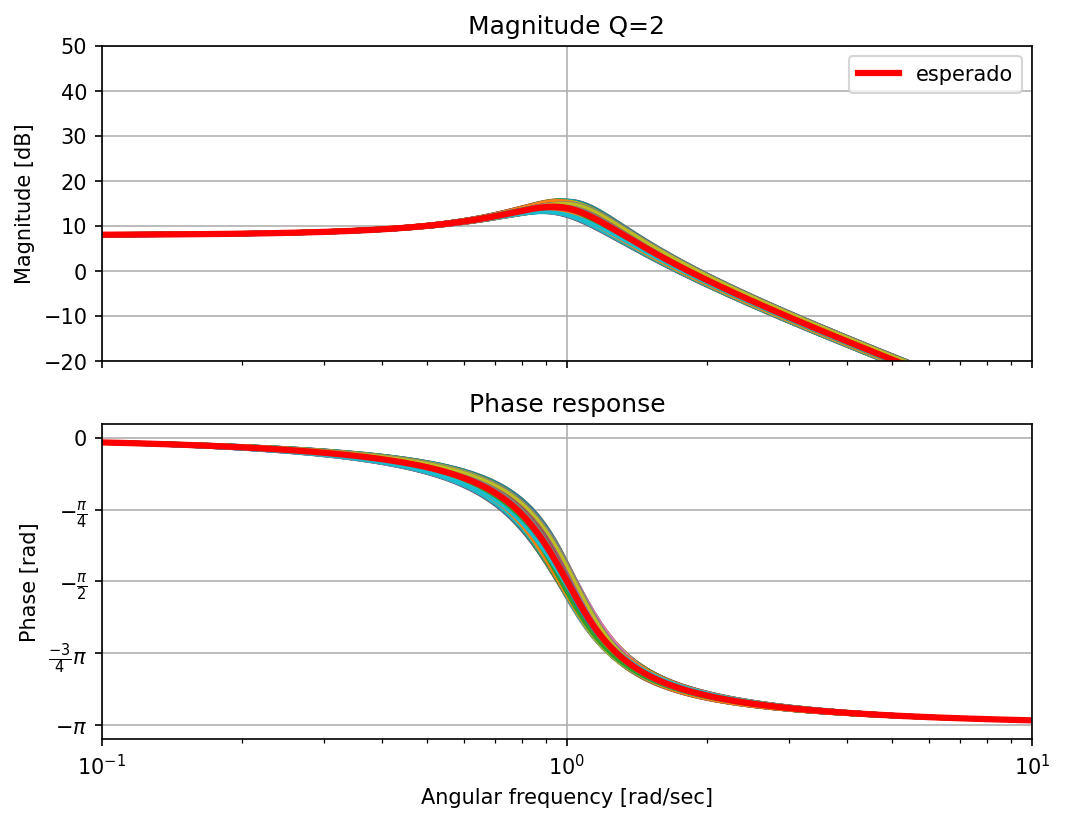

#### Transferencia sampleada al azar para Q=4

<IPython.core.display.Math object>

#### Transferencia deseada para Q=4

<IPython.core.display.Math object>

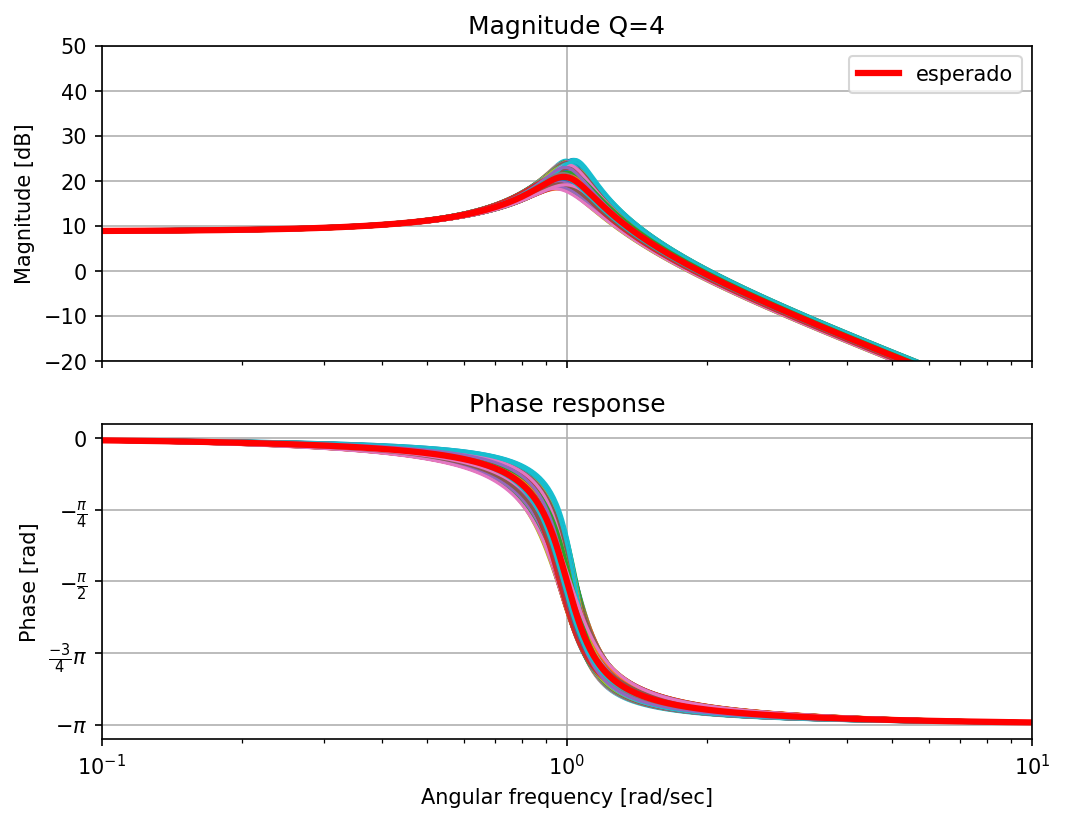

#### Transferencia sampleada al azar para Q=8

<IPython.core.display.Math object>

#### Transferencia deseada para Q=8

<IPython.core.display.Math object>

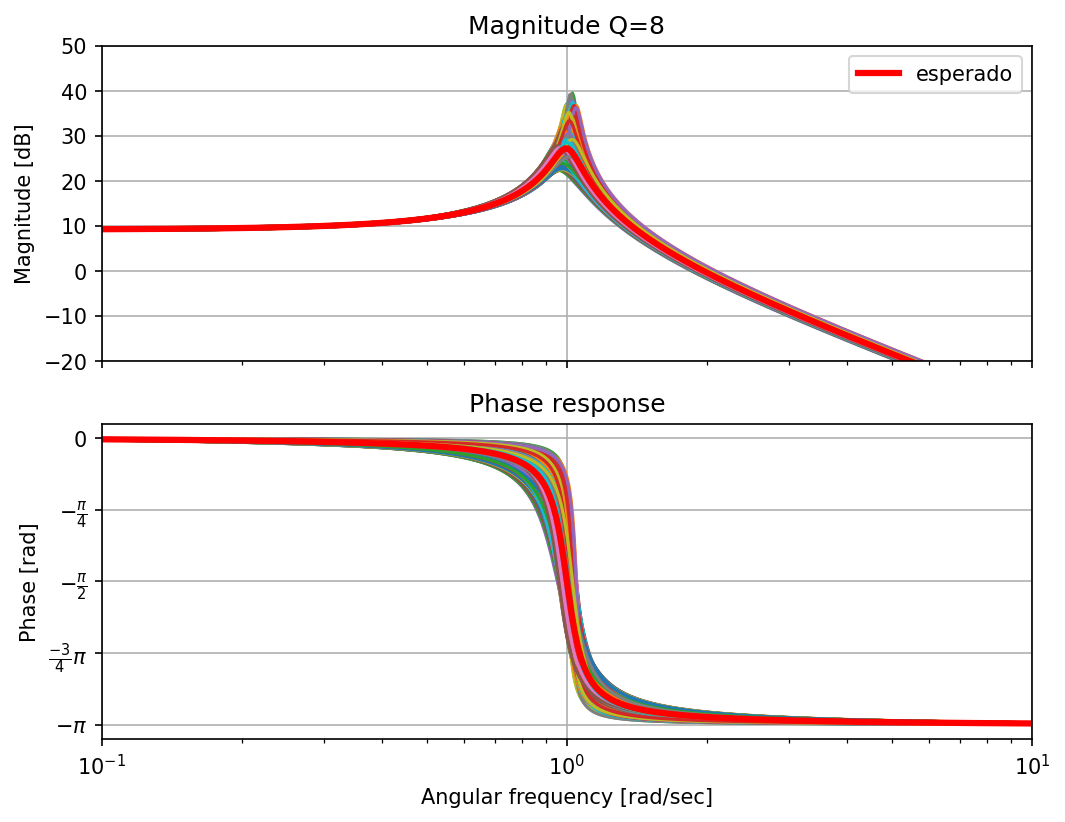

In [87]:
################
## simulación ##
################

def my_experiment( QQset ):
    # Cantidad de iteraciones o experimentos
    NN = 1000
    # Tolerancia de los componentes
    tol = 5

    # Q y \omega_0 proyectados
    QQ = QQset
    W0 = 1

    # Valores de los componentes 
    CC = 1
    RR = 1
    RB = (2-1/QQ)*RR

    # Valores de los componentes para cada iteración:
    # Cada valor es muestreado independientemente de una distribución uniforme,
    # limitada por la tolerancia impuesta.
    all_C = np.random.uniform(CC * (100-tol/2)/100 , CC * (100+tol/2)/100, size=NN )
    all_R = np.random.uniform(RR * (100-tol/2)/100 , RR * (100+tol/2)/100, size=NN )
    all_RB = np.random.uniform(RB * (100-tol/2)/100 , RB * (100+tol/2)/100, size=NN )

    plt.close('all')

    fig_hdl = plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    axes_hdl = fig_hdl.subplots(2, 1, sharex='col')
    fig_id = fig_hdl.number

    # analizaremos cada iteración resultante
    for (this_C, this_R, this_RB) in zip( all_C, all_R, all_RB):

        this_KK = 1 + this_RB/this_R
        this_QQ = 1/(3-this_KK)
        this_w0 = 1/this_R/this_C

        num = [this_KK * (this_w0**2)]
        den = [1, this_w0/this_QQ, this_w0**2]

        my_tf = TransferFunction( num, den )

        _, axes_hdl = bodePlot(my_tf, fig_id)


    # visualizamos la última realización a modo de ejemplo
    print_subtitle('Transferencia sampleada al azar para Q={:d}'.format(QQset))

    pretty_print_bicuad_omegayq(num,den)

    # finalmente ploteamos también la transferencia con los valores esperados
    # sin incertidumbre alguna sobre sus valores.
    KK = 1 + RB/RR
    QQ = 1/(3-KK)
    WW0 = 1/RR/CC

    num = [KK * (WW0**2)]
    den = [1, WW0/QQ, WW0**2]

    # visualizamos la transferencia esperada o media
    print_subtitle('Transferencia deseada para Q={:d}'.format(QQset))

    pretty_print_bicuad_omegayq(num,den)

    my_tf = TransferFunction( num, den )

    w, mag, phase = my_tf.bode(n=300)

    (mag_ax_hdl, phase_ax_hdl) = axes_hdl

    plt.sca(mag_ax_hdl)
    plt.semilogx(w, mag, '-r', label = 'esperado', linewidth=3 )    # Bode magnitude plot

    plt.title('Magnitude Q={:d}'.format(QQset))
    plt.legend()
    plt.ylim([-20, 50])

    plt.sca(phase_ax_hdl)
    plt.semilogx(w, phase*np.pi/180, '-r', linewidth=3)    # Bode phase plot
    plt.xlim([.1, 10])
    plt.show()
    
    return( all_C, all_R, all_RB )

all_Qset = [2, 4, 8]

all_C, all_R, all_RB = my_experiment( QQset = all_Qset[0] )

results = np.vstack([all_C, all_R, all_RB]).transpose()
list_results = [results]

for ii in range(1, len(all_Qset)):
    all_C, all_R, all_RB = my_experiment( QQset = all_Qset[ii] )
    results = np.vstack([all_C, all_R, all_RB]).transpose()
    list_results += [results]
    
results = np.stack( list_results, axis=2 )



In [88]:
results = np.stack( list_results, axis=2 )


Para luego analizar estadísticamente la distribución de cada parámetro.

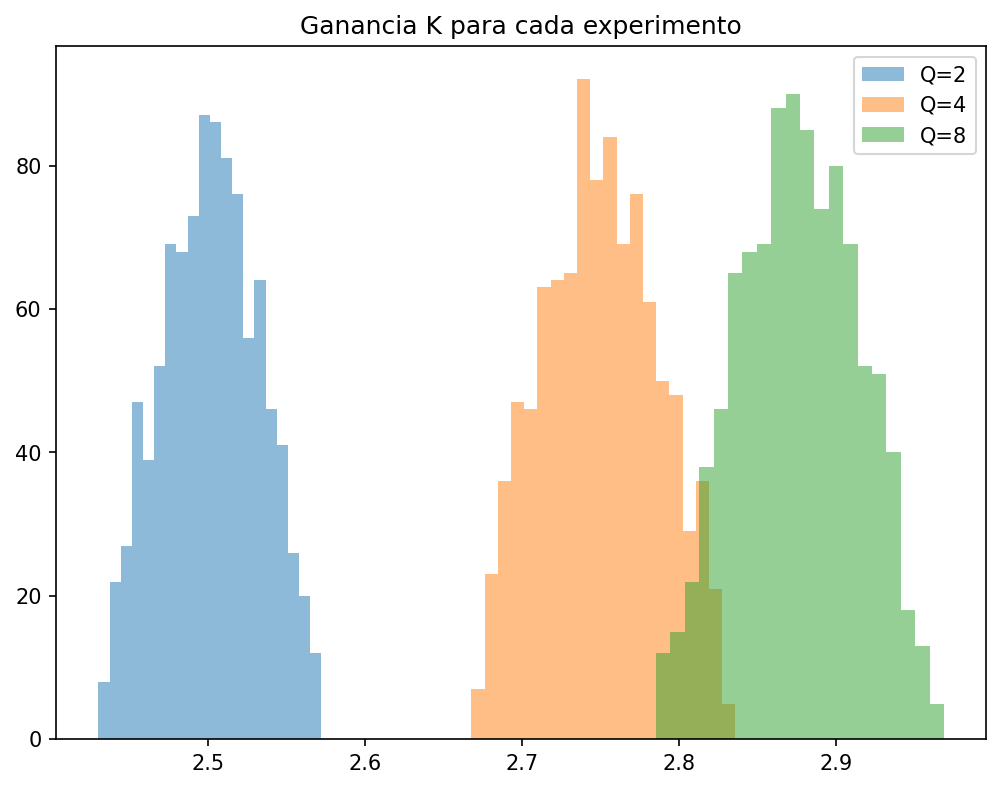

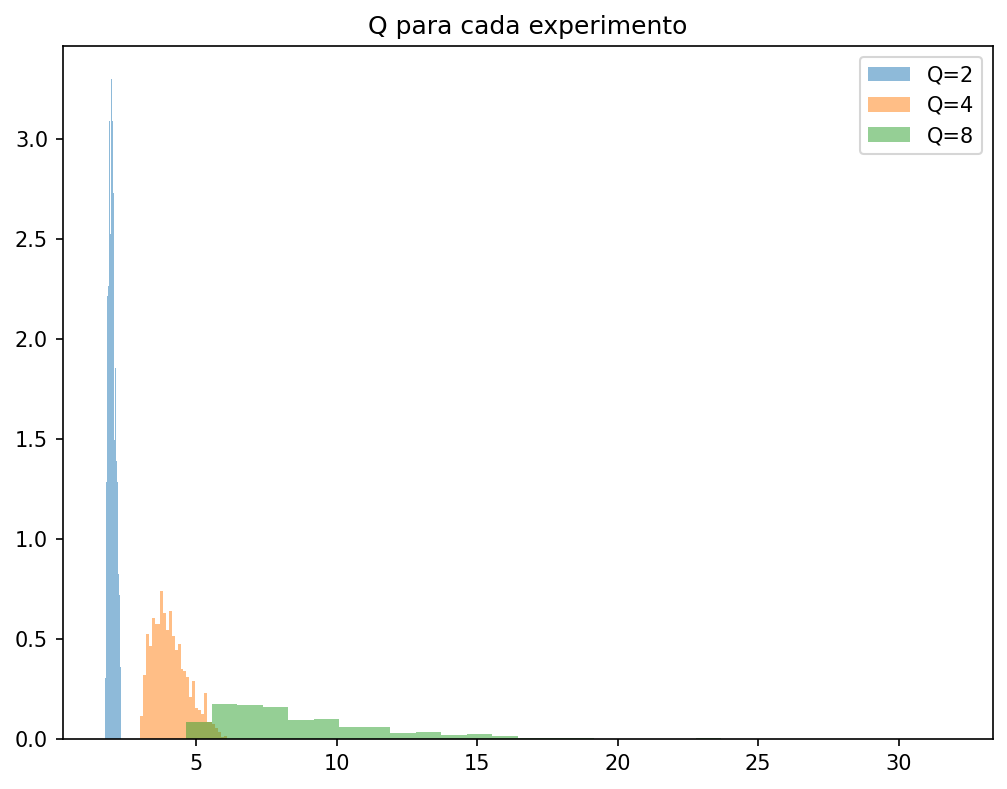

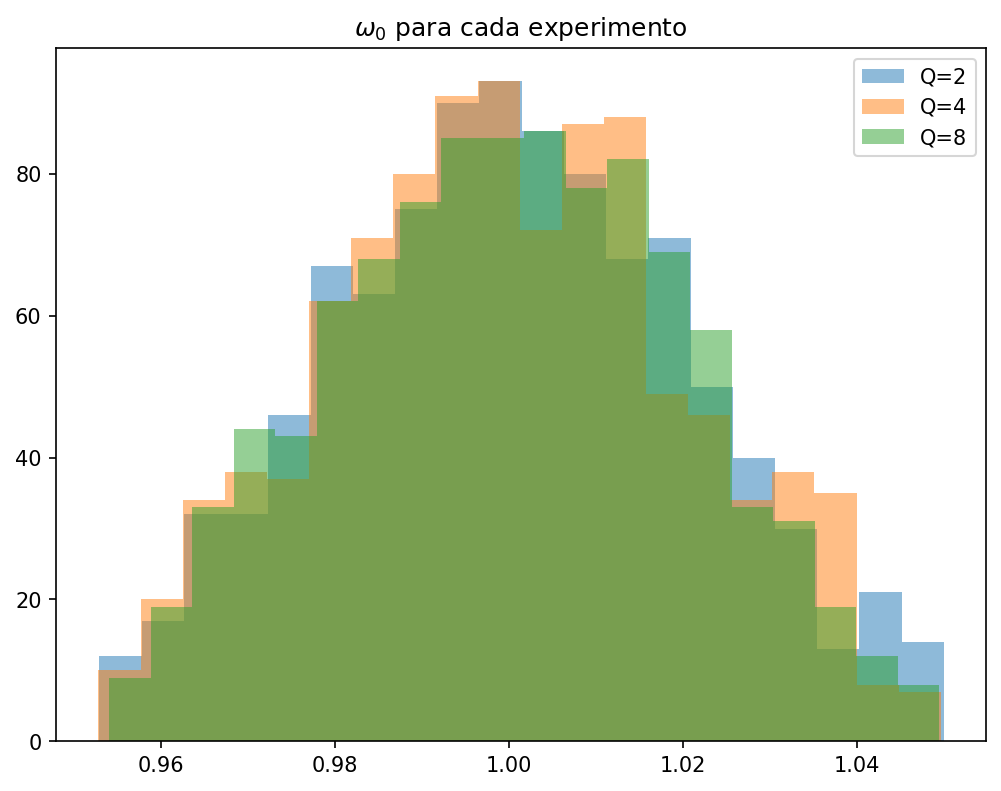

In [89]:
# Ahora vamos a hacer un estudio estadístico de los parámetros Q y \omega_0
# calculo los valores de los parámetros para TODAS las iteraciones
all_KK = 1 + results[:,2,:]/results[:,1,:]
all_QQ = 1/(3-all_KK)
all_w0 = 1/results[:,1,:]/results[:,0,:]

plt.figure()
#plt.hist( 20*np.log10(all_KK), 20 )

for ii in range(len(all_Qset)):
    plt.hist( all_KK[:,ii], 20, alpha=0.5, label='Q={:d}'.format(all_Qset[ii]) )
plt.title('Ganancia K para cada experimento')
plt.legend()

#plt.figure(figsize=(fig_sz_x*6/10, fig_sz_y*4/10), dpi= fig_dpi, facecolor='w', edgecolor='k')
plt.figure()
for ii in range(len(all_Qset)):
    plt.hist( all_QQ[:,ii], 30, alpha=0.5, density=True, label='Q={:d}'.format(all_Qset[ii]) )

#plt.xlim([0,20])
plt.title('Q para cada experimento')
plt.legend()

plt.figure()
for ii in range(len(all_Qset)):
    plt.hist( all_w0[:,ii], 20, alpha=0.5, label='Q={:d}'.format(all_Qset[ii]) )

plt.title('$\omega_0$ para cada experimento')
plt.legend()


Como se puede ver en los histogramas, la dispersión o varianza de los parámetros $\omega_0$ y $K$ no se ve alterada por el valor de $Q$ a implementar. Por otro lado, el parámetro $Q$ es el más afectado o sensible a la tolerancia de los componentes en la topología Sallen-Key. El $Q$ depende de la ganancia $K$, que a su vez depende de la relación de dos resistores ($R_a$ y $R_b$). Esta alta sensibilidad puede mitigarse, o bien utilizando resistores con tolerancias bajas (<= 1%), o limitando que el $Q$ a implementarse sea bajo, de forma tal que la ganancia a implementar no afecte tanto.

Finalmente se presenta un análisis cuantitativo de la dispersión de Q

In [105]:
# Pandas es un módulo para la gestión de tablas y análisis de datos
import pandas as pd

dfQ = pd.DataFrame(data = all_QQ, 
                  columns = all_Qset)

print_subtitle('Descripción cuantitativa de los valores de Q')

display(dfQ.describe())


#### Descripción cuantitativa de los valores de Q

,2,4,8
count,1000.000000,1000.000000,1000.000000
mean,2.013198,4.086836,9.052436
std,0.126430,0.634245,3.629604
min,1.754699,3.009047,4.655994
25%,1.917700,3.594737,6.557470
50%,2.006648,3.982492,8.068969
75%,2.103241,4.480571,10.441492
max,2.336634,6.085970,31.846033


Como se puede ver en el desvío standard (std) o en los valores mínimos y máximos la dispersión de $Q$ aumenta a medida que el Q a implementarse aumenta.

Esto mismo no se verifica para $K$ ni $\omega_0$ como se muestra a continuación.

In [107]:
dfK = pd.DataFrame(data = all_w0, 
                  columns = all_Qset)
print_subtitle('Descripción cuantitativa de los valores de ganancia $\omega_0$')

display(dfK.describe())

dfK = pd.DataFrame(data = all_KK, 
                  columns = all_Qset)
print_subtitle('Descripción cuantitativa de los valores de ganancia K')

display(dfK.describe())


#### Descripción cuantitativa de los valores de ganancia $\omega_0$

,2,4,8
count,1000.000000,1000.000000,1000.000000
mean,1.000390,0.999842,1.000176
std,0.020625,0.020466,0.019922
min,0.952866,0.952756,0.953988
25%,0.985453,0.985463,0.985523
50%,1.000070,0.999366,1.000360
75%,1.015195,1.013897,1.015072
max,1.050043,1.049688,1.049523


#### Descripción cuantitativa de los valores de ganancia K

,2,4,8
count,1000.000000,1000.000000,1000.000000
mean,2.501332,2.749674,2.875774
std,0.031090,0.036907,0.038231
min,2.430102,2.667669,2.785223
25%,2.478542,2.721816,2.847502
50%,2.501657,2.748901,2.876068
75%,2.524543,2.776814,2.904228
max,2.572034,2.835688,2.968599
